<a href="https://colab.research.google.com/github/lenocahya/ir_wisata_semarang/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index

In [1]:
import re
import string
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

**Membaca crawl_wisata.csv**

In [2]:
url = "https://raw.githubusercontent.com/lenocahya/ir_wisata_semarang/main/crawl_wisata.csv"
df = pd.read_csv(url)
df.head()

,no,title,content,clean_content,url
0,1,Puri Kayana Camping Ground,kangen ngecamp nggak nih? Cuss berkemah denga...,kangen ngecamp nggak nih cuss berkemah dengan...,https://visitjawatengah.jatengprov.go.id/id/re...
1,2,Mengunjungi Wisata Religi Nyatnyono,Desa Nyatnyono di lereng Gunung Ungaran dikena...,desa nyatnyono di lereng gunung ungaran dikena...,https://visitjawatengah.jatengprov.go.id/id/re...
2,3,"Candi Dukuh, Petilasan Prabu Brawijaya","Candi Dukuh terletak di Desa Rowoboni, Kecamat...",candi dukuh terletak di desa rowoboni kecamata...,https://visitjawatengah.jatengprov.go.id/id/re...
3,4,5 Hal Spesial Di Desa Wisata Lerep,Jalan-jalan ke Semarang? Mampirlah ke Desa Wis...,jalan jalan ke semarang mampirlah ke desa wisa...,https://visitjawatengah.jatengprov.go.id/id/re...
4,5,All In One In Sunrise Hill Gedong Songo,lagi cari referensi resto? Penginapan? Spot s...,lagi cari referensi resto penginapan spot sel...,https://visitjawatengah.jatengprov.go.id/id/re...


**Tokenization** memecah kata pada clean_content yang ada menggunakan

In [3]:
df_parse = df.copy()

cols = ["clean_content"]
for col in cols:
  df_parse[col] = df_parse[col].str.split()

df_parse.head()

,no,title,content,clean_content,url
0,1,Puri Kayana Camping Ground,kangen ngecamp nggak nih? Cuss berkemah denga...,"[kangen, ngecamp, nggak, nih, cuss, berkemah, ...",https://visitjawatengah.jatengprov.go.id/id/re...
1,2,Mengunjungi Wisata Religi Nyatnyono,Desa Nyatnyono di lereng Gunung Ungaran dikena...,"[desa, nyatnyono, di, lereng, gunung, ungaran,...",https://visitjawatengah.jatengprov.go.id/id/re...
2,3,"Candi Dukuh, Petilasan Prabu Brawijaya","Candi Dukuh terletak di Desa Rowoboni, Kecamat...","[candi, dukuh, terletak, di, desa, rowoboni, k...",https://visitjawatengah.jatengprov.go.id/id/re...
3,4,5 Hal Spesial Di Desa Wisata Lerep,Jalan-jalan ke Semarang? Mampirlah ke Desa Wis...,"[jalan, jalan, ke, semarang, mampirlah, ke, de...",https://visitjawatengah.jatengprov.go.id/id/re...
4,5,All In One In Sunrise Hill Gedong Songo,lagi cari referensi resto? Penginapan? Spot s...,"[lagi, cari, referensi, resto, penginapan, spo...",https://visitjawatengah.jatengprov.go.id/id/re...


In [4]:
# Memasukkan tokenisasi ke dalam df_doc
df_doc = pd.DataFrame(columns = ["document"])
df_doc["document"] = df_parse['clean_content']

df_doc.head()

,document
0,"[kangen, ngecamp, nggak, nih, cuss, berkemah, ..."
1,"[desa, nyatnyono, di, lereng, gunung, ungaran,..."
2,"[candi, dukuh, terletak, di, desa, rowoboni, k..."
3,"[jalan, jalan, ke, semarang, mampirlah, ke, de..."
4,"[lagi, cari, referensi, resto, penginapan, spo..."


**Menambahkan nilai ID dokumen dari lokasi kata ditemukan berdasarkan letak kata pada dokumen ke-n, n=index**

In [5]:
df_term = pd.DataFrame(columns = ["Term","DocID"])

size = df_doc.shape[0]
for index in range(size):
    row = df_doc['document'].iloc[index]

    for kata in row:
        df_term = df_term.append({"Term":kata,"DocID":index}, ignore_index=True)

In [6]:
df_term.head(100)

,Term,DocID
0,kangen,0
1,ngecamp,0
2,nggak,0
3,nih,0
4,cuss,0
...,...,...
95,banyubiru,2
96,kabupaten,2
97,semarang,2
98,masyarakat,2


In [7]:
df_term.shape

(5887, 2)

**Mengurutkan Term berdasar alfabetnya**

In [8]:
df_term_sorted = df_term.sort_values(by="Term")
df_term_sorted.head(10)

,Term,DocID
2044,abad,29
3281,abad,47
3092,abad,44
144,abad,2
3419,abdul,48
3212,abdul,46
2164,acara,30
4770,acara,65
2177,acara,30
767,ada,14


In [9]:
df_term_sorted.shape

(5887, 2)

## inverted index

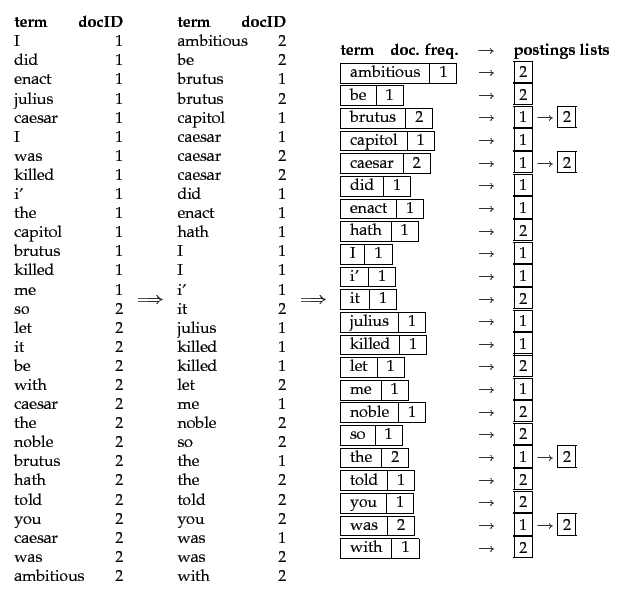

Sumber : https://nlp.stanford.edu/IR-book/html/htmledition/a-first-take-at-building-an-inverted-index-1.html


**Inisialisasi inverted index**

In [10]:
df_invertedindex = pd.DataFrame(columns = ["Terms","docFreq","postList"])
df_invertedindex

,Terms,docFreq,postList


In [11]:
# Memasukkan daftar term yang unique atau menggabungkan term yang sama menjadi 1
size = df_term_sorted.shape[0]
df_invertedindex['Terms'] = df_term_sorted['Term'].unique()

df_invertedindex.head()

,Terms,docFreq,postList
0,abad,NaN,NaN
1,abdul,NaN,NaN
2,acara,NaN,NaN
3,ada,NaN,NaN
4,adalah,NaN,NaN


In [12]:
# inisialisasi nilai
df_invertedindex["docFreq"]=0
df_invertedindex.head()

,Terms,docFreq,postList
0,abad,0,NaN
1,abdul,0,NaN
2,acara,0,NaN
3,ada,0,NaN
4,adalah,0,NaN


In [13]:
df_invertedindex.shape

(1892, 3)

In [14]:
ukuran = df_term_sorted.shape[0]
print(ukuran)
inverted_index_counter = 0
temp_list = [] 
for i in range(ukuran): # Melakukan looping sebanyak jumlah data berdasarkan ukuran tabel data term
  # Jika term pada df_term_sorted ke i identik dengan terms pada df_invertedindex index ke inverted_index_counter
  # Maka nilai inverted ditambah 1 terus hingga bertemu term yang sama terakhir
  if (df_term_sorted['Term'].iloc[i] == df_invertedindex['Terms'].iloc[inverted_index_counter]):
    df_invertedindex["docFreq"].iloc[inverted_index_counter]+=1
    temp_list.append(df_term_sorted["DocID"].iloc[i])
    df_invertedindex["postList"].iloc[inverted_index_counter] = temp_list
  
  # Setelah bertemu kata terakhir maka selanjutnya merubah nilai index dari inverted untuk membaca term selanjutnya
  # untuk dilakukan pencocokan dengan data term_sorted
  else :
    temp_list = []
    inverted_index_counter += 1
    df_invertedindex["docFreq"].iloc[inverted_index_counter] += 1
    temp_list.append(df_term_sorted["DocID"].iloc[i])
    df_invertedindex["postList"].iloc[inverted_index_counter] = temp_list


5887


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
print(df_invertedindex.head(10))

       Terms  docFreq                                           postList
0       abad        4                                    [29, 47, 44, 2]
1      abdul        2                                           [48, 46]
2      acara        3                                       [30, 65, 30]
3        ada       16  [14, 28, 70, 69, 68, 11, 36, 10, 63, 56, 35, 6...
4     adalah       20  [41, 33, 30, 38, 37, 35, 73, 57, 85, 15, 65, 8...
5   adaptasi        1                                               [78]
6       adat        2                                           [58, 58]
7  adrenalin        2                                            [9, 17]
8  advanture        1                                               [34]
9       agak        1                                               [81]


In [16]:
# Export to CSV
df_invertedindex.to_csv("invertedIndex.csv",index=False)